In [ ]:
# ! pip3 install matplotlib
# ! pip3 install seaborn
# ! pip3 install numpy
# ! pip3 install sklearn
# ! pip3 install empath


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import math
import empath

orig_data = pd.read_csv('/Users/preethi/Documents/Spring25/SC/SCProject/filtered_subreddits/SkincareAddiction_submissions.csv')
orig_data['date'] = pd.to_datetime(orig_data['created_utc'])
# Remove URLs using a regex

# Define a stronger regex for all types of URLs
url_pattern = r'(https?://\S+|www\.\S+|\S+\.(com|org|net|info|io|co)(\S*)?)'

# Remove URLs from the text column
orig_data['clean_text'] = orig_data['selftext_or_url_reference'].astype(str).str.replace(url_pattern, '', regex=True)

# Combine with title
orig_data['post'] = orig_data['title'].astype(str) + ' ' + orig_data['clean_text']


/Users/preethi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# utils
def plot_line_graph(df, title, xlabel, ylabel):
    # Set seaborn style
    sns.set(style='whitegrid')

    # Plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=xlabel, y=ylabel, data=df, linewidth=2.5)

    # Prettify
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

columns to analyse:

'score', 'created_utc', 'title','archived', 'locked', 'num_comments','over_18', 'removed_by_category', 'spoiler', 'ups', 'upvote_ratio', 'selftext_or_url_reference'

things to do:
- keywords over time -- DONE
- n-grams pre vs post -- DONE
- empath growth variation v baseline v one year down the line
- activity growth absolute -- DONE
- relative activity growth v baseline v one year down the line: posts, comments, upvote_ratio?, spoiler, over_18, archived, locked
- topic modelling 10 day period

*****ACTIVITY*****

**Number of posts changes in June 2023**

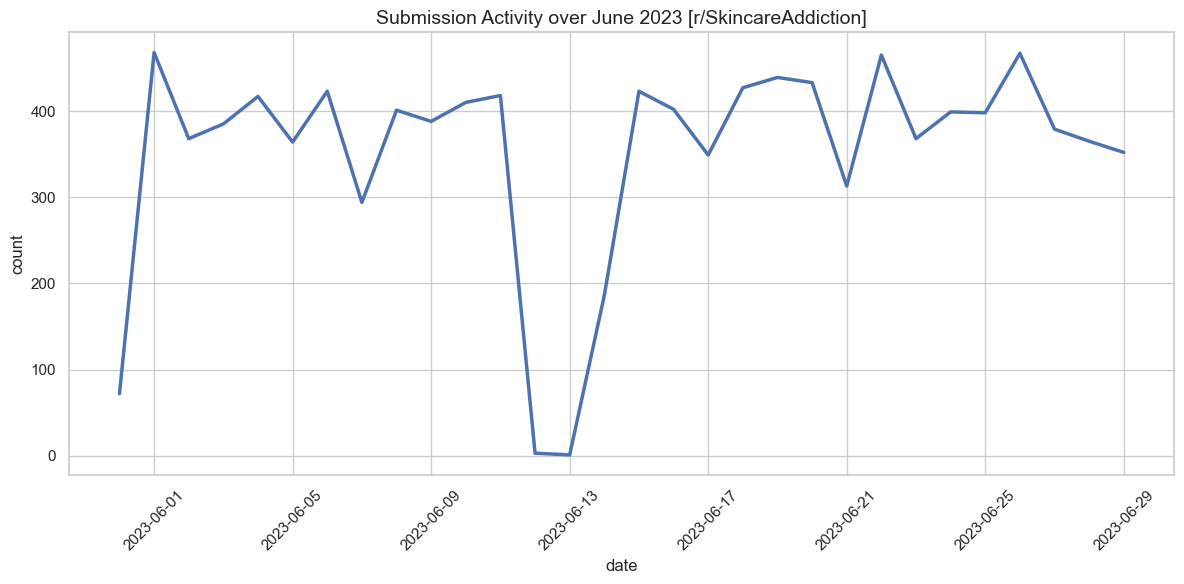

In [3]:
df = orig_data.groupby('date').size().reset_index(name='count').sort_values('date')
plot_line_graph(df, 'Submission Activity over June 2023 [r/SkincareAddiction]', 'date', 'count')

**Number of comments in June 2023**

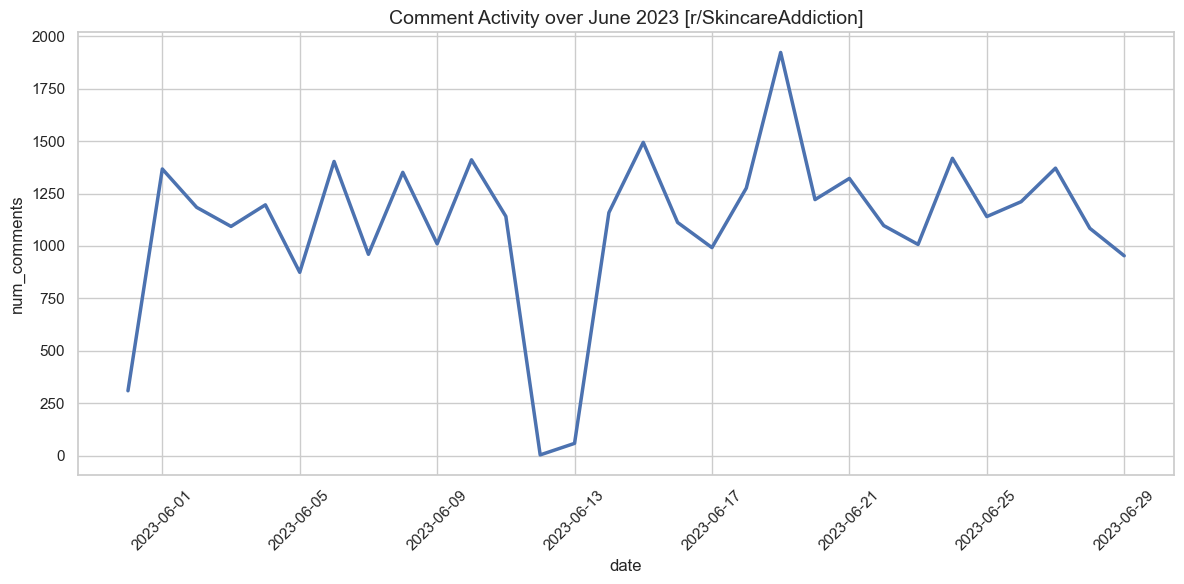

In [4]:
df = orig_data \
         .groupby('date')['num_comments'] \
         .sum() \
         .reset_index(name='num_comments') \
         .sort_values('date')
plot_line_graph(df, 'Comment Activity over June 2023 [r/SkincareAddiction]', 'date', 'num_comments')

**Agreement Levels (upvote_ratio) over June 2023**
notes: disagreements on the day before Jun 11, interestingly high upvotes on June 12 - 13. what happened on Jun 26??

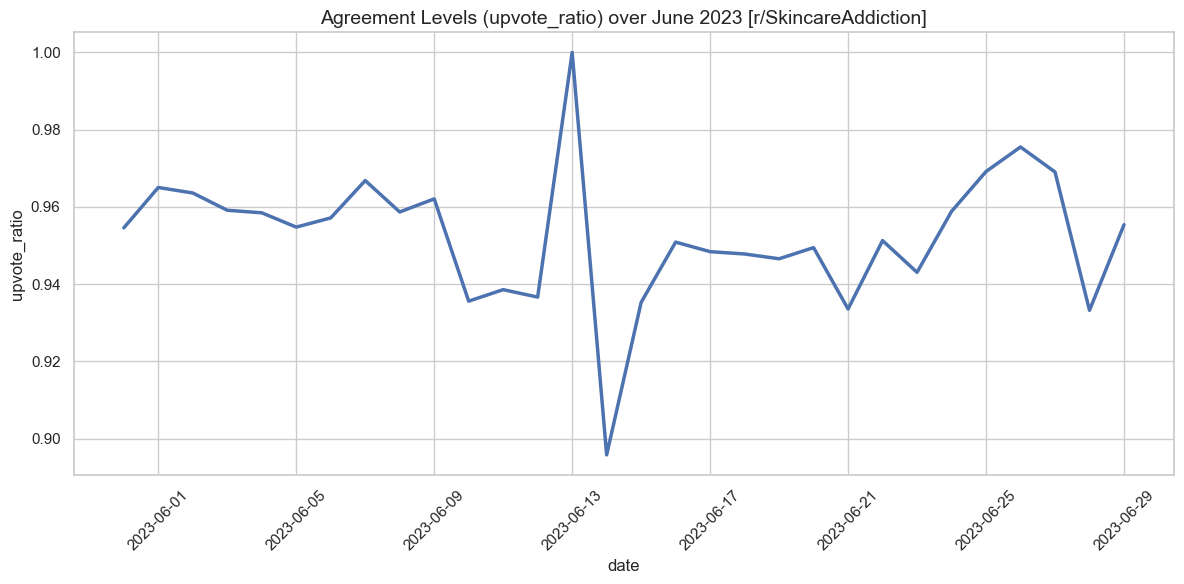

In [5]:
df = orig_data \
         .groupby('date')['upvote_ratio'] \
         .mean() \
         .reset_index(name='upvote_ratio') \
         .sort_values('date')
plot_line_graph(df, 'Agreement Levels (upvote_ratio) over June 2023 [r/SkincareAddiction]', 'date', 'upvote_ratio')

**Obscured content (spoiler + over_18) in June 2023**

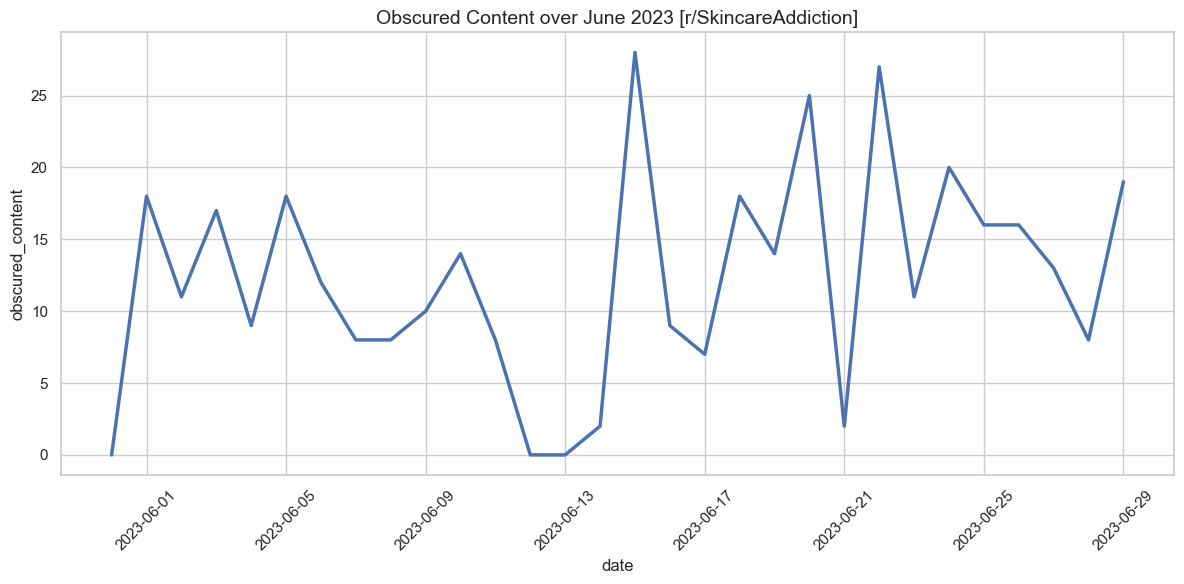

In [6]:
df = orig_data\
.groupby('date')[['spoiler', 'over_18']].sum().assign(obscured_content=lambda x: x['spoiler'] + x['over_18'])\
.reset_index().sort_values('date')
plot_line_graph(df, 'Obscured Content over June 2023 [r/SkincareAddiction]', 'date', 'obscured_content')

**Censorship in June 2023**

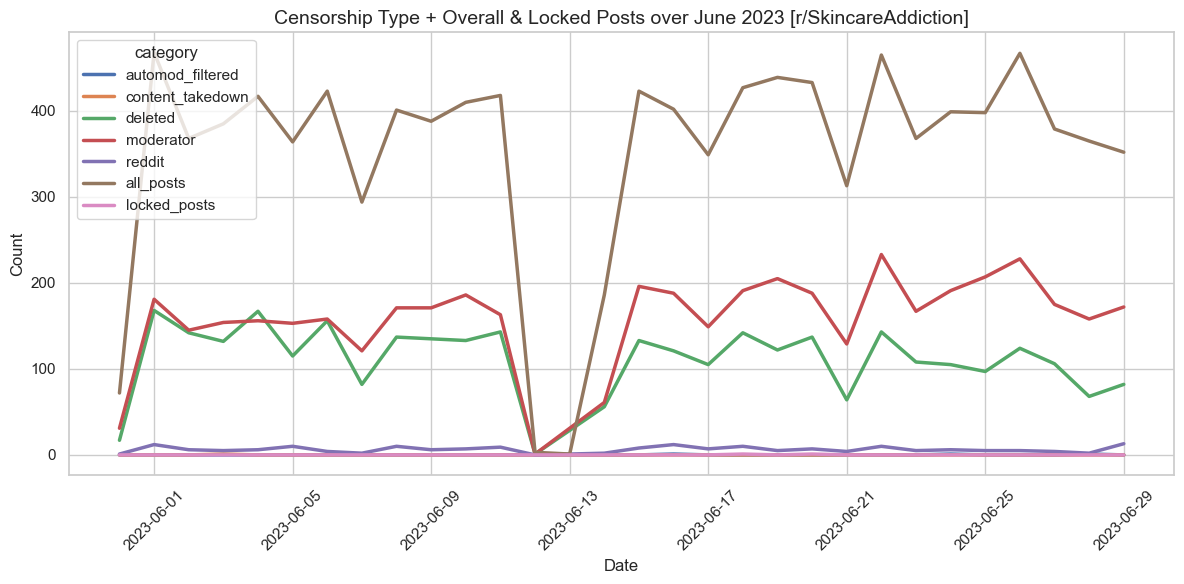

In [7]:
# Compute daily count of all posts
total_df = orig_data.groupby('date').size().reset_index(name='count')
total_df['category'] = 'all_posts'

# Compute daily sum of locked posts
locked_df = orig_data.groupby('date')['locked'].sum().reset_index(name='count')
locked_df['category'] = 'locked_posts'

# Group by date and removal category
df = orig_data.groupby(['date', 'removed_by_category']).size().unstack(fill_value=0).reset_index().sort_values('date')
df_melted = df.melt(id_vars='date', var_name='category', value_name='count')

# Combine everything
df_combined = pd.concat([df_melted, total_df, locked_df], ignore_index=True)

# Plot
sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_combined, x='date', y='count', hue='category', linewidth=2.5)

plt.title('Censorship Type + Overall & Locked Posts over June 2023 [r/SkincareAddiction]', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


*****N-GRAMS*****

/var/folders/sl/lp2z3s1x35qfm3vs1r5wjxmm0000gn/T/ipykernel_9213/3803390491.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


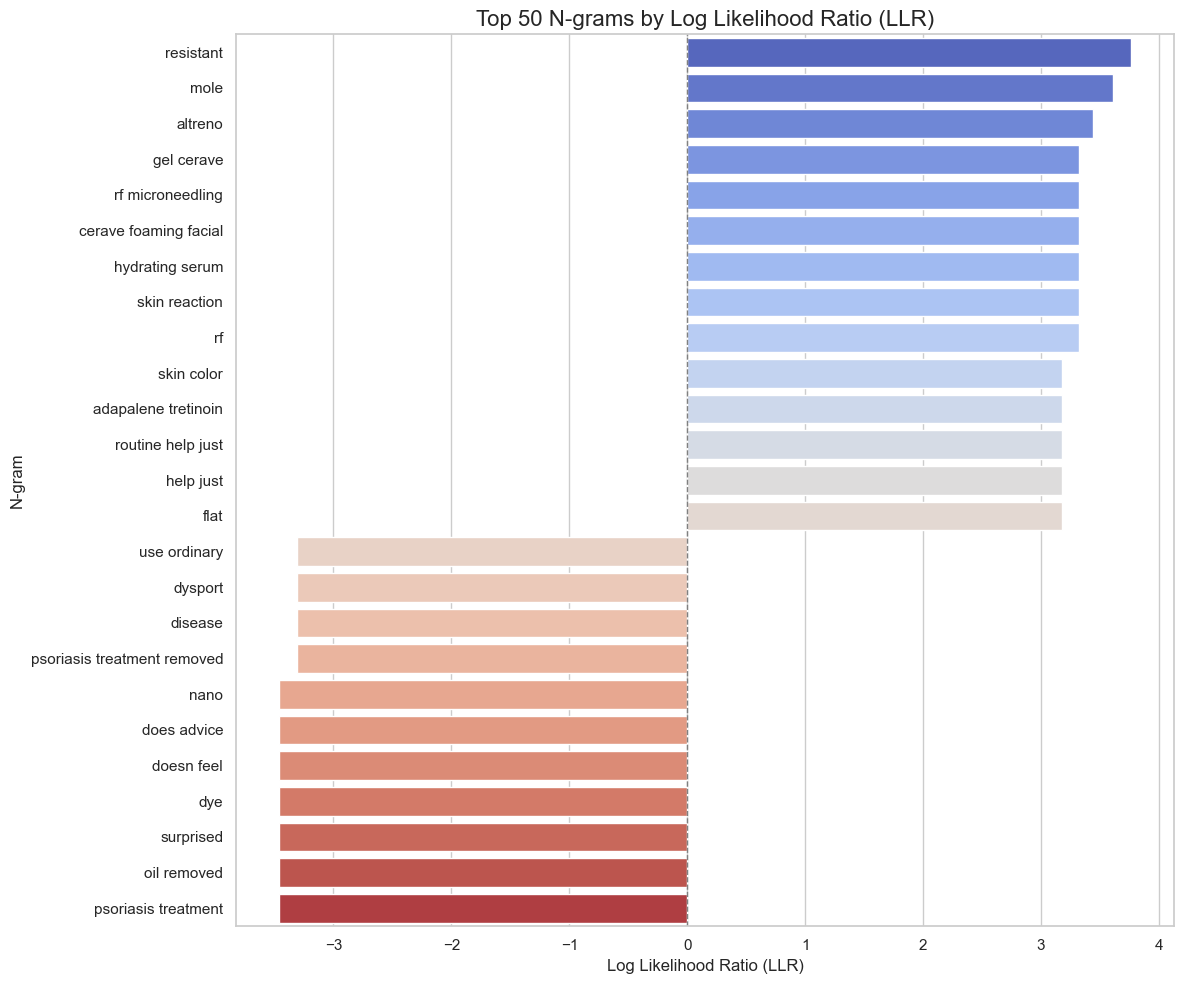

In [8]:
incident_date = datetime(2023, 6, 12)
# Create two time windows
before_mask = (orig_data['date'] >= incident_date - timedelta(days=7)) & (orig_data['date'] < incident_date)
after_mask  = (orig_data['date'] >= incident_date + timedelta(days=3)) & (orig_data['date'] < incident_date + timedelta(days=10))

text_col = 'post'  # or 'title' or a concat of both
before_texts = orig_data[before_mask][text_col].dropna().astype(str).tolist()
after_texts  = orig_data[after_mask][text_col].dropna().astype(str).tolist()

# Use CountVectorizer for n-gram extraction
vectorizer = CountVectorizer(ngram_range=(1, 3), max_features=10000, stop_words='english')
vectorizer.fit(before_texts + after_texts)

before_counts = vectorizer.transform(before_texts).sum(axis=0).A1
after_counts  = vectorizer.transform(after_texts).sum(axis=0).A1
vocab = np.array(vectorizer.get_feature_names_out())

# Total n-grams per period
total_before = before_counts.sum()
total_after = after_counts.sum()

# Add-1 smoothing and probability calculation
p_before = (before_counts + 1) / (total_before + len(vocab))
p_after  = (after_counts + 1) / (total_after + len(vocab))

# Log Likelihood Ratio
llr = np.log2(p_after / p_before)

# Build result DataFrame
result_df = pd.DataFrame({
    'ngram': vocab,
    'count_before': before_counts,
    'count_after': after_counts,
    'LLR': llr
}).sort_values('LLR', ascending=False)

# Get top 50 by absolute LLR magnitude
top_50 = result_df.reindex(result_df['LLR'].abs().sort_values(ascending=False).index).head(25)

# Show result
# Sort n-grams by LLR magnitude
top_50_sorted = top_50.sort_values('LLR', key=abs, ascending=False)

# Plot
plt.figure(figsize=(12, 10))
sns.barplot(
    data=top_50_sorted,
    y='ngram',
    x='LLR',
    palette='coolwarm',
    order=top_50_sorted.sort_values('LLR', ascending=False)['ngram']
)

plt.title('Top 50 N-grams by Log Likelihood Ratio (LLR)', fontsize=16)
plt.xlabel('Log Likelihood Ratio (LLR)', fontsize=12)
plt.ylabel('N-gram', fontsize=12)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

/var/folders/sl/lp2z3s1x35qfm3vs1r5wjxmm0000gn/T/ipykernel_9213/1067530780.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_subreddits, x='count', y='subreddit', palette='viridis')


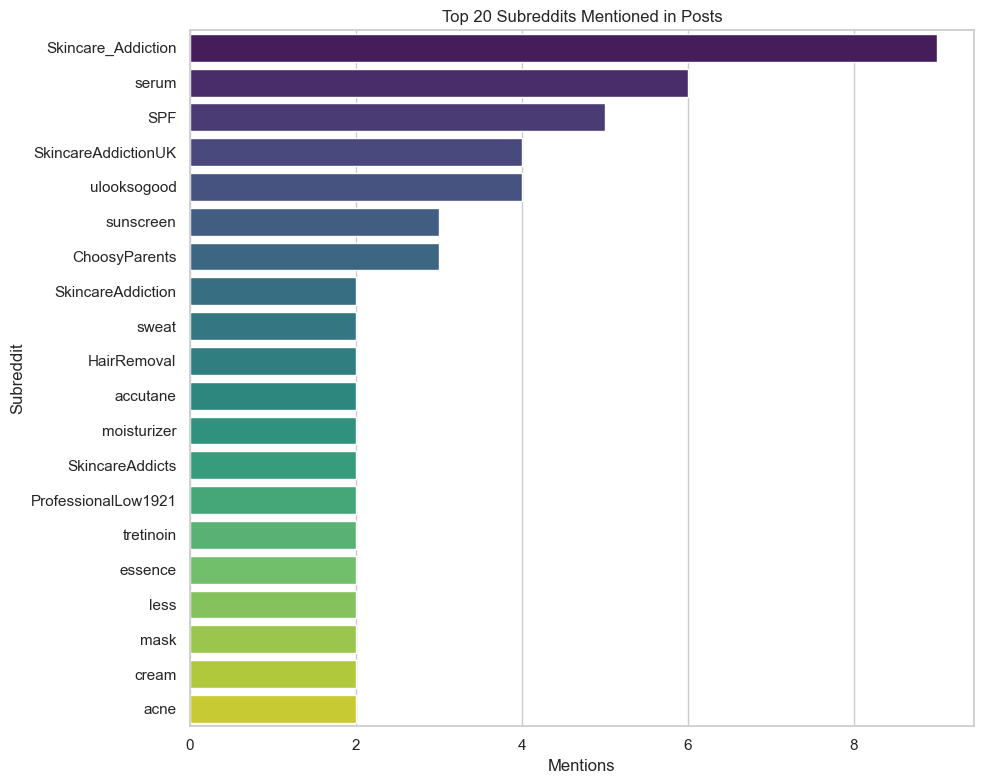

In [9]:
# Extract all subreddit mentions using regex: r/<subreddit
subreddit_mentions = orig_data['post'].str.extractall(r'r/([A-Za-z0-9_]+)')[0]

# Count mentions and get top 20
top_subreddits = subreddit_mentions.value_counts().head(20).reset_index()
top_subreddits.columns = ['subreddit', 'count']

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(data=top_subreddits, x='count', y='subreddit', palette='viridis')
plt.title('Top 20 Subreddits Mentioned in Posts')
plt.xlabel('Mentions')
plt.ylabel('Subreddit')
plt.tight_layout()
plt.show()

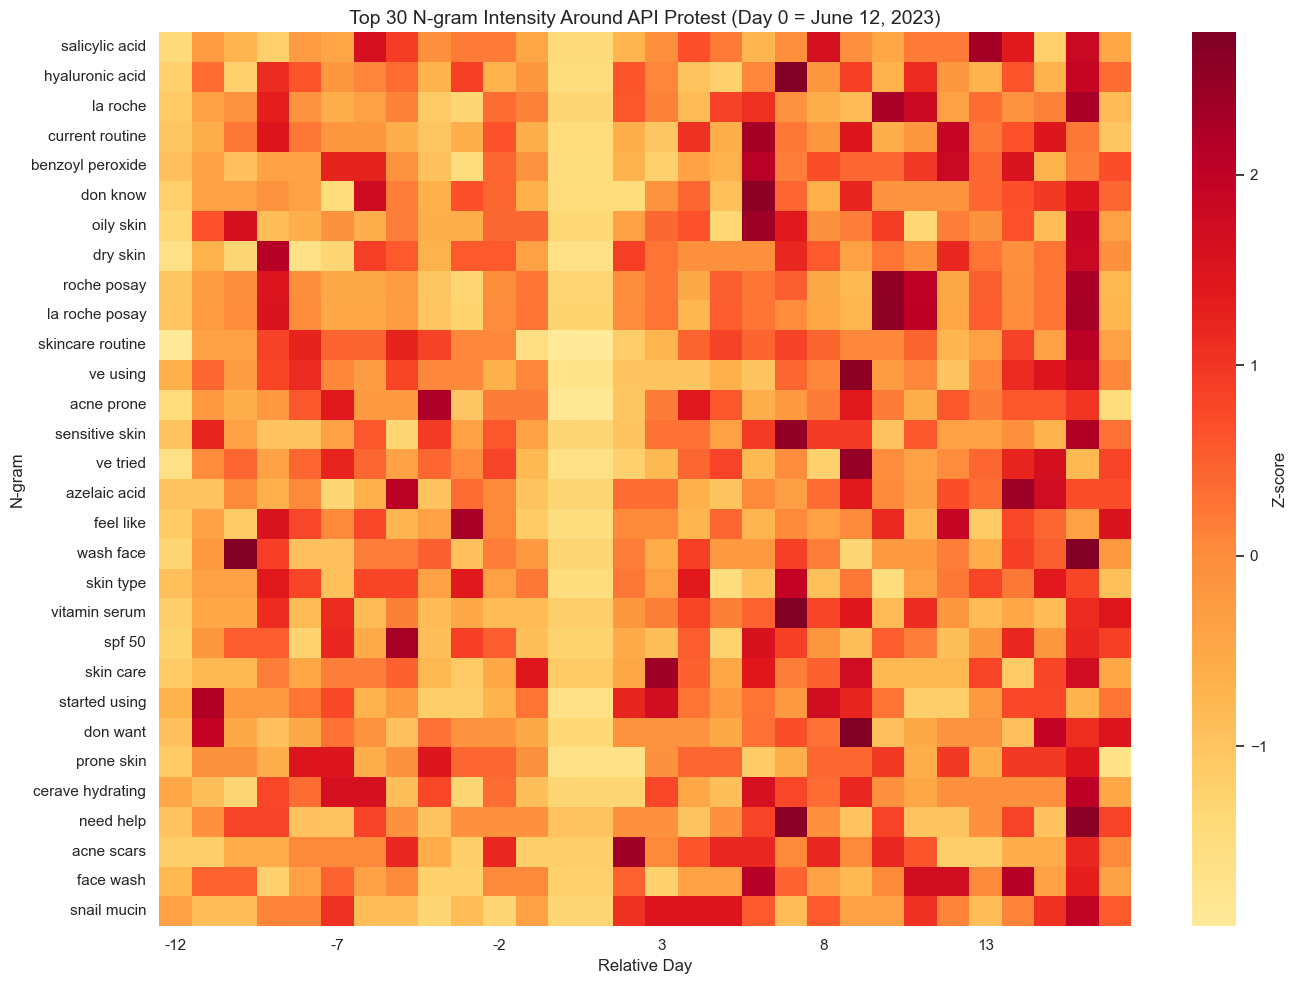

In [10]:
# 1. Relative day calculation
orig_data['rel_day'] = (orig_data['date'] - incident_date).dt.days

# 2. Filter to desired window (e.g. -30 to +30 days)
window = 30
windowed = orig_data[orig_data['rel_day'].between(-window, window)]

# 3. Extract n-gram frequencies (n = 1, 2, 3)
vectorizer = CountVectorizer(ngram_range=(2, 3), max_features=500, stop_words='english')
X = vectorizer.fit_transform(windowed['clean_text'])
vocab = np.array(vectorizer.get_feature_names_out())

# 4. Create term frequency DataFrame
term_freq = pd.DataFrame(X.toarray(), columns=vocab)
term_freq['rel_day'] = windowed['rel_day'].values

# 5. Group by rel_day (columns = days, rows = n-grams)
daily_matrix = term_freq.groupby('rel_day').sum().T

# 6. Normalize each n-gram row (z-score)
norm_matrix = (daily_matrix - daily_matrix.mean(axis=1).values[:, None]) / daily_matrix.std(axis=1).values[:, None]

# 7. Select top 30 high-frequency n-grams overall
top_words = daily_matrix.sum(axis=1).sort_values(ascending=False).head(30).index
plot_matrix = norm_matrix.loc[top_words].fillna(0)

# 8. Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(plot_matrix, cmap='YlOrRd', center=0, xticklabels=5, yticklabels=1, cbar_kws={'label': 'Z-score'})
plt.title('Top 30 N-gram Intensity Around API Protest (Day 0 = June 12, 2023)', fontsize=14)
plt.xlabel('Relative Day')
plt.ylabel('N-gram')
plt.tight_layout()
plt.show()

In [11]:
# Setup
from empath import Empath
from scipy.stats import ttest_ind

lexicon = Empath()
incident_date = pd.to_datetime("2023-06-12")

# Label posts as pre or post incident
orig_data['group'] = np.where(orig_data['date'] < incident_date, 'pre', 'post')

# Compute EMPATH scores per post
def get_empath_vector(text):
    scores = lexicon.analyze(text, normalize=True, categories=[
    'positive_emotion', 'negative_emotion', 'joy', 'anger', 'sadness', 'fear', 'emotional',
    'family', 'friends', 'children', 'social_media',
    'thinking', 'confusion', 'questioning', 'knowledge',
    'health', 'body', 'sleep', 'medical_emergency', 'eating',
    'power', 'money', 'leadership', 'politics', 'law',
    'work', 'education', 'technology', 'office',
    'past', 'present', 'future',
    'violence', 'death', 'suicide', 'crime', 'heroic',
    'swearing_terms', 'internet', 'journalism'
]
)
    return pd.Series(scores)

empath_df = orig_data['clean_text'].apply(get_empath_vector)
empath_df['group'] = orig_data['group'].values

# Split into groups
pre_df = empath_df[empath_df['group'] == 'pre'].drop(columns='group')
post_df = empath_df[empath_df['group'] == 'post'].drop(columns='group')

# T-test and mean differences
pvals = pd.Series({
    col: ttest_ind(pre_df[col], post_df[col], equal_var=False, nan_policy='omit').pvalue
    for col in pre_df.columns
})

/var/folders/sl/lp2z3s1x35qfm3vs1r5wjxmm0000gn/T/ipykernel_9213/1919225358.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=delta.values, y=delta.index, palette='coolwarm')


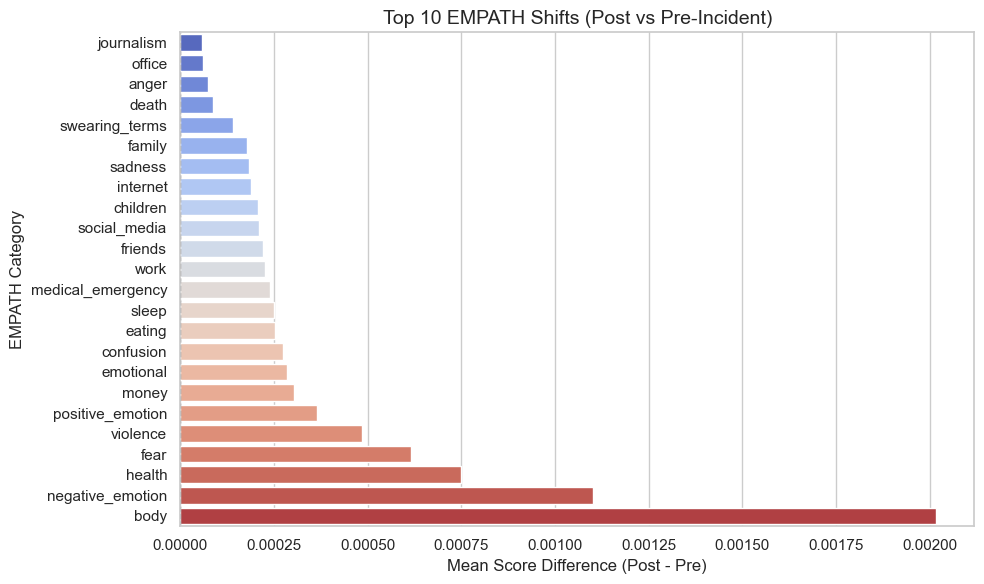

In [12]:

# Filter significant categories (p < 0.05)
significant = pvals[pvals < 0.05]
top_diff = significant.nsmallest(50).index.tolist()

# Mean differences
pre_mean = pre_df[top_diff].mean()
post_mean = post_df[top_diff].mean()
delta = post_mean - pre_mean
delta = delta.sort_values()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=delta.values, y=delta.index, palette='coolwarm')
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Top 10 EMPATH Shifts (Post vs Pre-Incident)', fontsize=14)
plt.xlabel('Mean Score Difference (Post - Pre)', fontsize=12)
plt.ylabel('EMPATH Category')
plt.tight_layout()
plt.show()